In [1]:
from pathlib import Path
from types import SimpleNamespace
import numpy as np
import torch

import matplotlib.pyplot as plt
import pandas as pd 

from train import TrainerDAGMM

In [2]:
args = SimpleNamespace(num_epochs=200)
args.lr = 1e-4
args.latent_dim = 2
args.n_gmm = 6
args.lambda_energy = 0.1
args.lambda_cov = 0.005
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(args)

namespace(num_epochs=200, lr=0.0001, latent_dim=2, n_gmm=6, lambda_energy=0.1, lambda_cov=0.005, device='cuda')


In [3]:
path = Path.home().joinpath("Documents","Data","Rehabilitation")
path.mkdir(exist_ok=True)
def get_data():
    X = pd.read_csv(path.joinpath("Data_Correct.csv"),header=None)
    Y = pd.read_csv(path.joinpath("Data_Incorrect.csv"),header=None)
    X = X.to_numpy()
    Y = Y.to_numpy()
    return X, Y

In [4]:
X, Y = get_data()
print(X.shape)
print(Y.shape)

(10530, 240)
(10530, 240)


In [5]:
n_dim = 117
T = X.shape[1]
R = int(X.shape[0]/n_dim)
def two2three(X, R, T, n_dim):
    X_NN = np.zeros((R,T,n_dim))
    for r in range(R):
        X_NN[r,:,:] = X[r*n_dim:(r+1)*n_dim,:].T
    X_NN = torch.tensor(X_NN).float()
    return X_NN.reshape((-1,n_dim))

In [6]:
X_NN = two2three(X, R, T, n_dim)
Y_NN = two2three(Y, R, T, n_dim)
print(X_NN.shape)
print(Y_NN.shape)

torch.Size([21600, 117])
torch.Size([21600, 117])


In [7]:
dagmm = TrainerDAGMM(args, X_NN)

In [8]:
z_c, x_hat, z, gamma = dagmm.model(X_NN.to(args.device))
z_c.shape, x_hat.shape, z.shape, gamma.shape

(torch.Size([21600, 2]),
 torch.Size([21600, 117]),
 torch.Size([21600, 4]),
 torch.Size([21600, 6]))

In [9]:
dagmm = TrainerDAGMM(args, X_NN)
dagmm.train()

Training DAGMM... Epoch: 0, Loss: 55.202
Training DAGMM... Epoch: 1, Loss: 52.220
Training DAGMM... Epoch: 2, Loss: 49.477
Training DAGMM... Epoch: 3, Loss: 46.950
Training DAGMM... Epoch: 4, Loss: 44.618
Training DAGMM... Epoch: 5, Loss: 42.462
Training DAGMM... Epoch: 6, Loss: 40.465
Training DAGMM... Epoch: 7, Loss: 38.613
Training DAGMM... Epoch: 8, Loss: 36.891
Training DAGMM... Epoch: 9, Loss: 35.290
Training DAGMM... Epoch: 10, Loss: 33.796
Training DAGMM... Epoch: 11, Loss: 32.400
Training DAGMM... Epoch: 12, Loss: 31.094
Training DAGMM... Epoch: 13, Loss: 29.870
Training DAGMM... Epoch: 14, Loss: 28.719
Training DAGMM... Epoch: 15, Loss: 27.636
Training DAGMM... Epoch: 16, Loss: 26.615
Training DAGMM... Epoch: 17, Loss: 25.650
Training DAGMM... Epoch: 18, Loss: 24.737
Training DAGMM... Epoch: 19, Loss: 23.871
Training DAGMM... Epoch: 20, Loss: 23.048
Training DAGMM... Epoch: 21, Loss: 22.266
Training DAGMM... Epoch: 22, Loss: 21.521
Training DAGMM... Epoch: 23, Loss: 20.810
Tr

In [10]:
with torch.no_grad():
    z, x_hat, aug_z, gamma = dagmm.model(X_NN.to(args.device))
    print(z.shape, x_hat.shape, aug_z.shape, gamma.shape)
    
    # compute phi, mu, and cov using the training dataset
    hp_gmm = dagmm.compute.compute_params(aug_z, gamma)
    print(hp_gmm[0].shape, hp_gmm[1].shape, hp_gmm[2].shape)
    
    # reshape data to compute negative log likelihood
    aug_z = aug_z.reshape((R,T,args.latent_dim+2))
    zy, y_hat, aug_zy , _ = dagmm.model(Y_NN.to(args.device))
    aug_zy = aug_zy.reshape((R,T,args.latent_dim+2))
    print(aug_z.shape, aug_zy.shape)
    
    # compute likelihood for correct and incorrect motions
    lik = {"corr":[],"incorr":[]}
    for r in range(R):
        cl,_ = dagmm.compute.compute_energy(aug_z[r], gamma, *hp_gmm)
        lik["corr"].append(-cl.cpu())
        il,_ = dagmm.compute.compute_energy(aug_zy[r], gamma, *hp_gmm)
        lik["incorr"].append(-il.cpu())

torch.Size([21600, 2]) torch.Size([21600, 117]) torch.Size([21600, 4]) torch.Size([21600, 6])
torch.Size([6]) torch.Size([6, 4]) torch.Size([6, 4, 4])
torch.Size([90, 240, 4]) torch.Size([90, 240, 4])


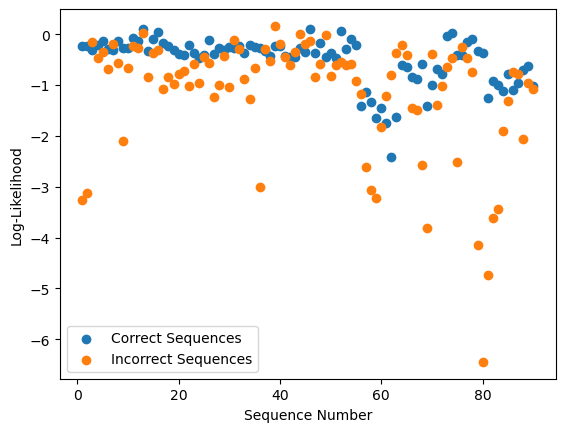

In [11]:
plt.scatter(np.arange(1,91),lik["corr"], label = "Correct Sequences")
plt.scatter(np.arange(1,91),lik["incorr"], label = "Incorrect Sequences")
plt.xlabel("Sequence Number")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.show()